# Reproduce: Quantum electrodynamics near a photonic bandgap (Preliminary)

Yanbing Liu and Andrew A Houck, Quantum electrodynamics near a photonic bandgap, Nat. Phys., (2016).

Reproduced by <strong>Eunjong Kim</strong> (eunjongkim@caltech.edu)

## Import Modules

In [1]:
# Setup for symbolic calculation
import sympy as sp
sp.init_printing()

In [2]:
# Setup for numerical calculation
import numpy as np
import numpy.linalg as la
from scipy.optimize import fsolve, brentq
from scipy.integrate import quad

In [3]:
# Setup for plots
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

##  Dispersion relation and the band structure

### Symbolic Calculation using the transfer matrix method

In this section, we derive the equation (1) of this paper using the SymPy module (symbolic calulation).

In [4]:
# Define symbolic variables corresponding to frequency,
# wavevector, and size of the unit cell
omega = sp.Symbol(r'\omega')
k = sp.Symbol(r'k')
d = sp.Symbol(r'd')

In [5]:
# Define a list of phase velocity, characteristic impedance,
# and length of each section of the unit cell
v = [sp.Symbol(r'v_{p1}'), sp.Symbol(r'v_{p2}')]
Z = [sp.Symbol(r'Z_{1}'), sp.Symbol(r'Z_{2}')]
l = [sp.Symbol(r'l_{1}'), sp.Symbol(r'l_{2}')]

We define the transfer matrix (ABCD) of each coplanar waveguide (CPW) section,

In [6]:
def CPW_ABCD(omega, idx):
    """
    Construct an ABCD matrix (symbolic) of the coplanar waveguide of specified index
    """
    A = sp.cos(omega * l[idx] / v[idx])
    B = sp.I * sp.sin(omega * l[idx] / v[idx]) * Z[idx]
    C = sp.I * sp.sin(omega * l[idx] / v[idx]) / Z[idx]
    D = sp.cos(omega * l[idx] / v[idx])
    return sp.Matrix([[A, B], [C, D]])

#def qubit_ABCD(omega):
#    A = 1
#    B = 0
#    C = - sp.I * gamma / (omega-omega_a) / Z0
#    D = 
#    return sp.Matrix([[A, B], [C, D]])

The transfer matrix $M_\textrm{unit}$ is the product of that of each section:

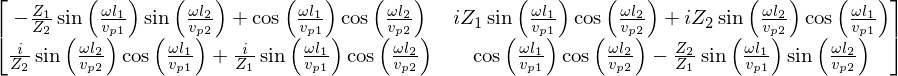

In [7]:
M_unit = CPW_ABCD(omega, 0) * CPW_ABCD(omega, 1)
M_unit

For a periodic system, the voltage $V(x, t)$ and current $I(x, t)$ should be of the Bloch form,
$$
\begin{bmatrix} V(0, t) \\ I(0, t) \end{bmatrix}
= M_\textrm{unit}
\begin{bmatrix} V(d, t) \\ I(d, t) \end{bmatrix} = M_\textrm{unit}e^{ikd}\begin{bmatrix} V(0, t) \\ I(0, t) \end{bmatrix},
$$
so that
$$
M_\textrm{unit}\begin{bmatrix} V(0, t) \\ I(0, t) \end{bmatrix}
= e^{-ikd}\begin{bmatrix} V(0, t) \\ I(0, t) \end{bmatrix}.
$$

We require that the determinant of $ e^{ikd} M_\textrm{unit} - I$ be zero for non-trivial solutions, and we get the following dispersion relation:

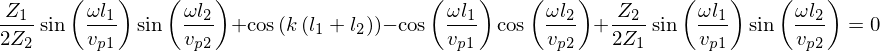

In [8]:
Expr = sp.simplify(sp.det(M_unit * sp.exp(sp.I*k*d) - sp.eye(2))/(2 * sp.exp(sp.I*k*d))).subs(d, sum(l))
sp.Eq(Expr, 0)

Assuming the same phase velocity in all sections, $v_{p} \equiv v_{p1} = v_{p2}$

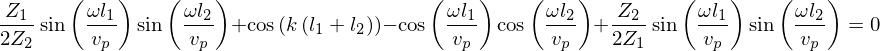

In [9]:
v_p = sp.Symbol('v_p')
Expr = Expr.subs({v[0]: v_p, v[1]: v_p})
sp.Eq(Expr, 0)

Thus, the Equation (1) is obtained.

### Evaluation of the band structure

From this dispersion relation, it is possible to numerically evaluate the band structure. First, we put the values of parameters. 
The eigenfrequency of the second band at $k=\pi/d$ is given by $\omega_0 /2\pi= 7.7\textrm{ GHz}$. The parameters corresponding to lengths $l$ and the impedances $Z$ are: $l_1 = 0.45\mathrm{\ mm}$, $l_2 = 8\mathrm{\ mm}$, $Z_1 = 28\mathrm{\ \Omega}$, $Z_2 = 125\mathrm{\ \Omega}$.

In [10]:
# values of parameters in SI units
omega0 = 2 * np.pi * 7.7e9

l_values = [0.45e-3, 8e-3]
Z_values = [28, 125]
d = sum(l_values)

In [11]:
dict_items = []
for idx in range(2):
    dict_items.append((l[idx], l_values[idx]))
    dict_items.append((Z[idx], Z_values[idx]))

We can compute the value of the phase velocity $v_p$ (assuming $v_{p1} = v_{p2}$) using the dispersion relation and $\omega = \omega_0$ at $k = \pi/d$

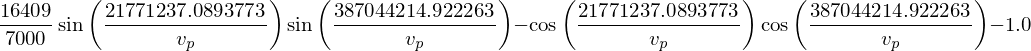

In [12]:
Expr_ = Expr.subs(dict_items)
expr_ = Expr_.subs({omega: omega0, k: np.pi/d}); expr_

In [13]:
func = sp.lambdify(v_p, expr_, "numpy")
v_p_value = fsolve(func, omega0/(np.pi/d))[0]; v_p_value

Thus the value of the phase velocity is estimated as $v_p = 1.248 \times 10^{8} \mathrm{\ m/s}$. Using this, we calculate the band structure from the dispersion relation

In [14]:
expr = Expr_.subs(v_p, v_p_value)
func = sp.lambdify((omega, k), expr, "numpy")

In [15]:
# Number of k-points to evaluate
N_kPts = 100
# Number of bands to evaluate
N_band = 4

kPts = np.linspace(- np.pi / d, np.pi / d, N_kPts)

In [16]:
freq = np.zeros((N_band, N_kPts))

for n in range(N_band):
    for idx, k_ in enumerate(kPts):
        # search for eigenfrequency between
        # n v_p k_0 and (n+1) v_0 k_0 (k_0 = \pi / d)
        freq[n, idx] = brentq(func, n * (v_p_value * np.pi / d),
                              (n + 1) * (v_p_value * np.pi / d),
                              args=(k_)) / (2 * np.pi)

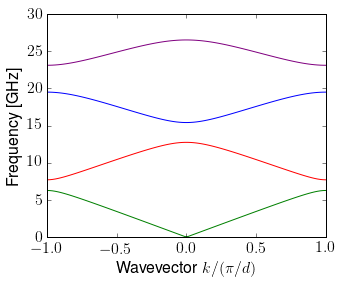

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig_colors = ['green','red','blue', 'purple']
for n in range(N_band):
    ax.plot(kPts / (np.pi / d), freq[n, :] / 1e9, color=fig_colors[n])

ax.set_xlabel(r'Wavevector $k/(\pi/d)$');
ax.set_ylabel('Frequency [GHz]');

## Numerical Calculation of the band and mode structures from the differential equation

### PDE Solving using the discretization

To analyze the mode structure (Bloch wavefunction) of an infinite microwave photonic crystal, we solve the following series of differential equations

$$
\frac{\partial}{\partial x} V(x, t) = -l(x) \frac{\partial}{\partial t} I(x,t), \quad \frac{\partial}{\partial x} I(x, t) = -c(x) \frac{\partial}{\partial t} V(x,t)
$$

which reduces to a single partial differential equation of $V(x, t)$

$$
\frac{\partial}{\partial x} \left[ \frac{v_p}{Z_c(x)} \frac{\partial V(x,t)}{\partial x}\right]
= \frac{1}{v_p Z_c(x)} \frac{\partial^2}{\partial t^2} V(x,t)
$$

The characteristic impedance $Z_c(x) = \sqrt{l(x)/c(x)}$ inside the unit cell ($-d/2< x < d/2$) is let to be
$$
Z_c (x) = 
$$
while the phase velocity $v_p = 1/\sqrt{l(x)c(x)}$ is a constant.

The time-independent ODE is obtained by separation of variables $V(x, t) = V(x) e^{i\omega t}$
$$
\frac{d}{dx} \left[\frac{1}{Z_c(x)} \frac{dV(x)}{dx}\right] = - \left(\frac{\omega}{v_p}\right)^2 \frac{V(x)}{Z_c(x)}
$$

We solve the partial differential equation




For numerical calculation of the mode structure, we impose the periodic boundary condition $Z_c(x) = Z_c(x+d)$ Fourier series expand $1/Z_c(x)$ as
$$
\frac{1}{Z_c (x)} = \sum_{m} \eta_{m} e^{i2\pi m x/d}.
$$

Here the Fourier coefficients $\eta_m$ are written as
$$\eta_m = \frac{1}{d} \int_{-d/2}^{d/2} dx \frac{e^{-i 2\pi m x/d}}{Z_c(x)}$$

In [18]:
# Characteristic impedance inside the unit cell
def Zc(x):
    return Z_values[1] * ((x > - l_values[1] / 2) * (x < l_values[1] / 2)) \
           + Z_values[0] * ((x < - l_values[1] / 2) + (x > l_values[1] / 2))

def eta(n_):
    """
    The n-th discrete Fourier coefficient of 1/Zc(x).
    Imaginary part vanishes due to the even parity of Zc(x)
    with respect to the x = 0 plane.
    """
    integrand = lambda x: (1 / Zc(x) * np.exp(-2j*np.pi*n_*x/d))
    return quad(integrand, -d/2, d/2)[0] / d

In [19]:
N_xPts = 100
xPts = np.linspace(- d/2, d/2, N_xPts)

In [20]:
# discrete Fourier space dimension
L = 10
n = np.arange(- 2 * L, 2 * L + 1)

# 
eta_array = np.zeros(4 * L + 1)
for n_ in n:
    eta_array[n_ + 2 * L] = eta(n_)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/integrate/quadpack.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


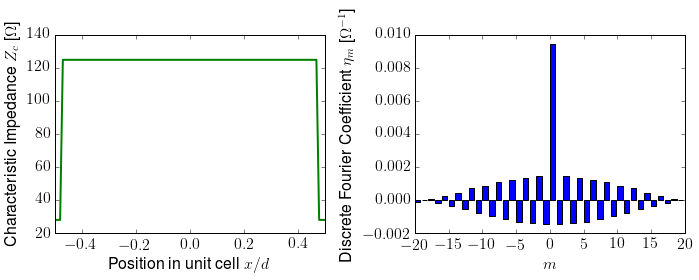

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(xPts/d, Zc(xPts), color=fig_colors[0], lw=2)
axes[0].set_xlabel('Position in unit cell $x/d$')
axes[0].set_ylabel(r'Characteristic Impedance $Z_c$   [$\Omega$]')
axes[0].set_xlim([-1/2, 1/2]);

axes[1].bar(n, eta_array, color=fig_colors[2]);
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([-2*L, 2*L]);
axes[1].set_ylabel(r'Discrete Fourier Coefficient $\eta_m$  [$\Omega^{-1}$]')
fig.tight_layout();

To solve this differential equation, we introduce eigenfunctions of the Bloch form $V_k(x) = u_k(x) e^{ikx}$ which satisfies $u_k(x+d) = u_k(x)$ and thus can be Fourier series expanded as
$$ u_k(x) = \sum_{m} c_{k,m} e^{i2\pi m x/d}$$

$$
\frac{d}{dx} \left[\sum_{m} \eta_{m} e^{i2\pi m x/d} \frac{d}{dx}\sum_{m'} c_{k,m'} e^{i(k+2\pi m' /d)x}\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m} \eta_{m} e^{i2\pi m x/d}\sum_{m'} c_{k,m'} e^{i(k+2\pi m' /d)x}
$$

$$
\frac{d}{dx} \left[\sum_{m,m'} \eta_{m} i\left(k+\frac{2\pi m'}{d}\right)c_{k,m'} e^{i[k+2\pi (m+m') /d]x}\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m,m'} \eta_{m} c_{k,m'} e^{i[k+2\pi (m+m') /d)]x}
$$

$$
\sum_{m,m'} \eta_{m} i\left(k+\frac{2\pi m'}{d}\right)i\left(k+\frac{2\pi (m+m')}{d}\right) c_{k,m'} e^{i[k+2\pi (m+m') /d]x} = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m,m'} \eta_{m} c_{k,m'} e^{i[k+2\pi (m+m') /d)]x}
$$

We introduce a new index $n$ to replace $m = n-m'$
$$
-\sum_{m', n} \eta_{n-m'} \left(k+\frac{2\pi m'}{d}\right)\left(k+\frac{2\pi n}{d}\right) c_{k,m'} e^{i(k+2\pi n /d)x} = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m',n} \eta_{n-m'} c_{k,m'} e^{i(k+ 2\pi n /d)x}
$$

Applying the inverse Fourier transform $\frac{1}{d}\int_{-d/2}^{d/2} dx \ e^{-i(k+2\pi m/d)x}$,
$$
-\sum_{m', n} \eta_{n-m'} \left(k+\frac{2\pi m'}{d}\right)\left(k+\frac{2\pi n}{d}\right) c_{k,m'}\left[ \frac{1}{d}\int_{-d/2}^{d/2}dx\ e^{i2\pi (n-m)x /d }\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m',n} \eta_{n-m'} c_{k,m'}\left[ \frac{1}{d}\int_{-d/2}^{d/2}dx\ e^{i2\pi (n-m)x /d }\right]
$$

The delta function identity
$$
\frac{1}{d}\int_{-d/2}^{d/2} dx\ e^{i2\pi (n-m)x /d} = \delta_{n,m}
$$
reduces the equation into a summation only in one index $m'$
$$
\sum_{m'} \eta_{m-m'} \left(k + \frac{2\pi m}{d}\right)\left(k + \frac{2\pi m'}{d}\right) c_{k, m'}
=  \left(\frac{\omega}{v_p}\right)^2 \sum_{m'} \eta_{m-m'} c_{k,m'}
$$

By identifying the matrices $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{c}$ as

$$[\mathbf{A}]_{m, m'} = \eta_{m-m'},\quad
[\mathbf{B}]_{m, m'} = \eta_{m-m'} \left(k + \frac{2\pi m}{d}\right) \left(k + \frac{2\pi m'}{d}\right),\quad
[\mathbf{c}]_m' = c_{k, m'},$$

This is a matrix equation $\mathbf{B}\mathbf{c} = (\omega/v_p)^2 \mathbf{A}\mathbf{c}$ which can be viewed as an eigenequation
$$(\mathbf{A}^{-1}\mathbf{B})\mathbf{c} = \left(\frac{\omega}{v_p}\right)^2 \mathbf{c}$$

In [22]:
A = np.zeros((2 * L + 1, 2 * L + 1))
for i in range(2 * L + 1):
    for j in range(2 * L + 1):
        m, m_ = i - L, j - L   # index offset
        A[i, j] = eta_array[m - m_ + 2 * L]

def B(k):
    temp = np.zeros((2 * L + 1, 2 * L + 1))
    for i in range(2 * L + 1):
        for j in range(2 * L + 1):
            m, m_ = i - L, j - L   # index offset
            temp[i, j] = (eta_array[m - m_ + 2 * L]
                          * (k + 2 * np.pi * m / d)
                          * (k + 2 * np.pi * m_ / d))
    return temp

def Op(k):
    return np.dot(la.inv(A), B(k))

In [23]:
def solve_eigenequation(k):
    eig_vals, eig_vecs = la.eig(Op(k))
    # sorting eigenvalues and eigenvectors
    idx = eig_vals.argsort()
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    
    eig_freq = np.sqrt(eig_vals) * v_p_value / (2*np.pi)
    return eig_freq, eig_vecs

In [24]:
def Bloch_wavefunc(x, c):
    """`1
    Given the amplitudes [c],
    Calculate the Bloch wavefunction

        u_k (x) = sum_{n} c_{k, n} exp(i2\pi n x/d)

    and return its absolute value.
    """
    V = np.zeros(len(x))
    for n in range(2 * L + 1):
        V = V + c[n] * np.exp(2j * np.pi * (n - L) * x / d)
    return abs(V)

In [25]:
X, Y = np.meshgrid(kPts, xPts)

N_modes = 2  # Number of modes to consider
eig_funcs = []
eig_freqs = []
for n in range(N_modes):
    eig_funcs.append(np.zeros((len(kPts), len(xPts))))
    eig_freqs.append(np.zeros(len(kPts)))

In [26]:
for idx, k_ in enumerate(kPts):
    eig_vals, eig_vecs = solve_eigenequation(k_)
    for n in range(N_modes):
        eig_funcs[n][:, idx] = Bloch_wavefunc(xPts, eig_vecs[:, n])
        eig_freqs[n][idx] = eig_vals[n]

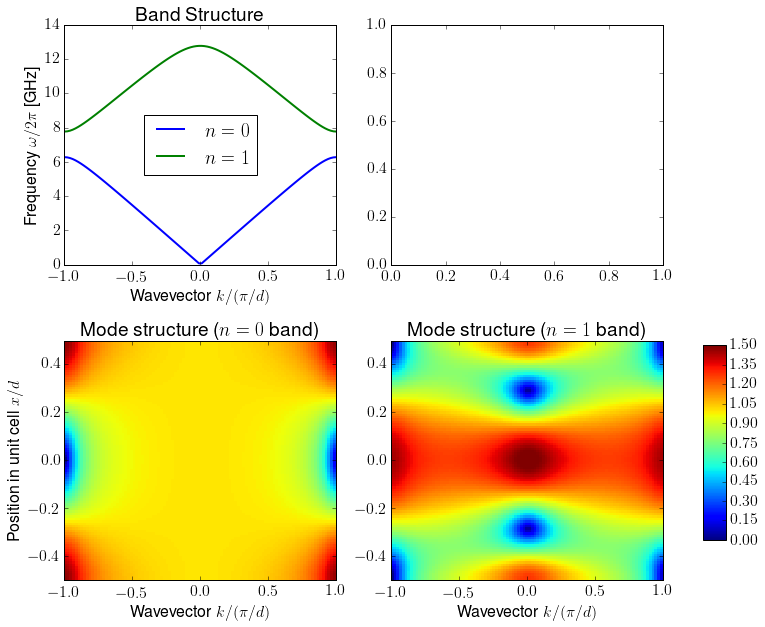

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Band structure
for n in range(N_modes):
    axes[0, 0].plot(kPts/(np.pi/d), eig_freqs[n]/1e9, label=r'$n=%d$' % n, lw=2)
axes[0, 0].set_xlabel(r'Wavevector  $k/(\pi/d)$')
axes[0, 0].set_ylabel(r'Frequency $\omega/2\pi$   [GHz]')
axes[0, 0].set_title('Band Structure')
axes[0, 0].legend(loc=0)

# Mode structure
p0 = axes[1, 0].pcolor(X/(np.pi/d), Y/d, eig_funcs[0], cmap=cm.jet, vmin=0, vmax=1.5)
p1 = axes[1, 1].pcolor(X/(np.pi/d), Y/d, eig_funcs[1], cmap=cm.jet, vmin=0, vmax=1.5)
axes[1, 0].set_xlabel(r'Wavevector  $k/(\pi/d)$'); axes[1, 1].set_xlabel(r'Wavevector  $k/(\pi/d)$')
axes[1, 0].set_ylabel(r'Position in unit cell  $x/d$')
axes[1, 0].set_xlim([-1, 1]); axes[1, 1].set_xlim([-1, 1])
axes[1, 0].set_ylim([-0.5, 0.5]); axes[1, 1].set_ylim([-0.5, 0.5])
axes[1, 0].set_title(r'Mode structure ($n=0$ band)')
axes[1, 1].set_title(r'Mode structure ($n=1$ band)');
fig.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.3])
fig.colorbar(p1, cax=cbar_ax);

## Version Information

In [28]:
%reload_ext version_information

%version_information sympy, numpy, scipy, matplotlib

Software versions
Python 3.4.5 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
IPython 5.0.0
OS Darwin 15.6.0 x86_64 i386 64bit
sympy 1.0
numpy 1.11.1
scipy 0.18.0
matplotlib 1.5.2
Mon Aug 22 11:31:23 2016 PDT